<a href="https://colab.research.google.com/github/neillinehan/NeilLinehanPortfolio/blob/main/dtl_data_interpolation_toolkit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Functions and Imports

In [ ]:
import pandas as pd

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from IPython.display import display, Markdown

In [ ]:
#for questions: Author: Neil Linehan, email: neiledwardlinehan@gmail
def get_year_sheet_cell(start_year_in_K1, target_year):
    """
    This function calculates the cell reference for a given year based on the year in cell K1.

    Parameters:
    start_year_in_K1 (int): The year in cell K1.
    target_year (int): The target year for which we want to find the cell reference.

    Returns:
    value str: This string of values has proper spaces so Google Sheets will automatically place them correctly.
    str: The cell reference for the target year.
    """
    # Define the mapping of column letters
    column_letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'] + [chr(65+i)+chr(65+j) for i in range(26) for j in range(26)]

    # Calculate the difference between the start year in K1 and the target year
    diff = target_year - start_year_in_K1

    # Get the column letter for the target year
    column_letter = column_letters[10 + diff]  # 10 is the index for 'K'

    return column_letter + '1'


def reported_data_to_sheet(years, values, pct=False,instructions=True):
    """
    This function generates a string of numbers that can be pasted into Google Sheets, corresponding to the appropiate spacing expected from the years data.

    Parameters:
    years (array-like): The years for which we have data.
    values (array-like): The corresponding values for each year.
    start_year_in_K1 (int): The year in cell K1 of the spreadsheet.
    pct (bool): If True, the values will be converted to percentages.
    instructions (bool): If True, instructions will be printed.

    Returns:
    str: Reported data with appropiate spacing for easy 1-click pasting into Google Sheets.
    """
    # Create a dictionary with years as keys and values as values
    year_value_dict = {year : (str(value) +'%' if pct else value) for year, value in zip(years, values)}

    # Create a string that Google Sheets will recognize
    output_string = '\t'.join([str(year_value_dict.get(year, '')) for year in range(min(years), max(years)+1)])
    print('Years of reported data:', years)
    print_header('For Reported row:')
    if instructions:
      print('\nStep 1: Copy the following string of numbers:')
    print('\n',output_string,'\n')
    if instructions:
      print('Step 2: In your Google Sheets, locate the cell that corresponds to the first year of the reported data.')
      print('Step 3: Paste without formatting the copied string into the located cell. The numbers will automatically fill the cells for each corresponding year.')


def Sheets_formula_regression(years, values, start_year_in_K1=2010,pct=False,instructions=True):
    """
    This function generates data and a formula for a polynomial regression model, which can be used in a spreadsheet.

    Parameters:
    years (array-like): The years for which we have data.
    values (array-like): The corresponding values for each year.
    start_year_in_K1 (int): The year in cell K1 of the spreadsheet.
    pct (bool): If True, the values will be converted to percentages.
    instructions (bool): If True, instructions will be printed.

    Returns:
    str: The formula for the polynomial regression model, with cell references based on the year in cell K1.
    """
    # Transform the data into polynomial features
    degree =1
    poly_features = PolynomialFeatures(degree=degree)
    x_poly = poly_features.fit_transform(years.reshape(-1, 1))


    # Train the linear regression model
    model = LinearRegression()
    model.fit(x_poly, values)

    r_squared = model.score(x_poly, values)
    #iterate until fitted
    while r_squared < .99 and (poly_features.degree < 5):
        poly_features = PolynomialFeatures(degree=poly_features.degree + 1)
        degree = poly_features.degree
        print('Poly degree testing:',degree)
        x_poly = poly_features.fit_transform(years.reshape(-1, 1))
        model = LinearRegression()
        model.fit(x_poly, values)
        r_squared = model.score(x_poly, values)




    print(f'R-squared: {r_squared}')
    coefficients = model.coef_
    # Predict the output
    y_pred = model.predict(x_poly)

    # Plot the data and the model
    plt.scatter(years, values, color='blue', label='Data')
    plt.plot(years, y_pred, color='red', label='Model')
    plt.annotate(f'Degree: {degree}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12)
    plt.title('Polynomial Regression')
    plt.xlabel('Year')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    # Create a dictionary with years as keys and values as values
    year_value_dict = {year: value for year, value in zip(years, values)}

    reported_data_to_sheet(years, values,pct,instructions)

    # Get the cell reference for the first year in the data
    cell = get_year_sheet_cell(start_year_in_K1, years[0])
    print('\n')
    print_header('For interpolation row:')
    if instructions:
      print('\nStep 1: Copy the following formula:')
    print()
    if pct:
      print(f'=({model.intercept_}', end='')
    else:
      print(f'={model.intercept_}', end='')
    for i in range(1, len(coefficients)):
      print(f' + {coefficients[i]}*{cell}^{i}', end='')
    print(')/100', end='') if pct else print()
    print()
    if instructions:
      print('Step 2: In your Google Sheets, locate the cell that corresponds to the first year of the reported data.')
      print('Step 3: Paste the copied formula into the located cell. Drag or ctrl-r to fill the formula into other cells.')
    return

# Create a function to print headers
def print_header(text):
  header = Markdown("## " + text)
  display(header)

##Example 1: IEA ETP 2017 2DS China and World Road and WTW data

In [ ]:
#All below copied from spreadsheet. https://docs.google.com/spreadsheets/d/1JXzSThL7QSMAVgcoqORWjrIfOhKiFEDJ/edit?usp=drive_link&ouid=108202743678991601203&rtpof=true&sd=true

years = np.array([2014, 2025, 2030, 2035, 2040, 2045, 2050, 2055, 2060])

china_light_road_freight = [25, 79, 119, 156, 192, 229, 266, 305, 335]
world_light_road_freight = [1266, 1566, 1794, 1998, 2179, 2352, 2535, 2729, 2915]
china_heavy_road_freight = [5604, 9024, 11352, 13464, 15437, 17441, 19681, 22091, 24562]
world_heavy_road_freight = [26523, 38049, 45529, 52909, 59878, 66879, 74463, 82508, 90850]

world_light_road_activ = [32959,	39658,	42301,	44192,	45511,	46889,	48162,	49362,	50478]
china_light_road_activ = [6879,	9176,	9412,	9172,	8773,	8616,	8428,	8219,	8027]
world_heavy_road_activ = [7343, 8955, 10084, 11324, 12588, 13833, 15085, 16282, 17507]
china_heavy_road_activ = [1594, 1549, 1603, 1656, 1692, 1752, 1783, 1785, 1797]


world_WTW_light_road = [4804, 4236, 3839, 3376, 2863, 2371, 1909, 1529, 1268]
world_WTW_heavy_road = [2527, 2856, 2961, 2894, 2683, 2427, 2181, 1838, 1518]
china_WTW_light_road = [536, 615, 550, 446, 353, 264, 191, 141, 103]
china_WTW_heavy_road = [440, 493, 520, 504, 464, 425, 394, 346, 295]


ETP_raw = [world_WTW_light_road,china_WTW_light_road,
           world_WTW_heavy_road,china_WTW_heavy_road,
           world_light_road_activ,china_light_road_activ,
           world_heavy_road_activ,china_heavy_road_activ,
           world_light_road_freight,china_light_road_freight,
           world_heavy_road_freight,china_heavy_road_freight,
           ]

variable_names = ['world_WTW_light_road',
                  'china_WTW_light_road',
                  'world_WTW_heavy_road',
                  'china_WTW_heavy_road',
                  'world_light_road_activ',
                  'china_light_road_activ',
                  'world_heavy_road_activ',
                  'china_heavy_road_activ',
                  'world_light_road_freight',
                  'china_light_road_freight',
                  'world_heavy_road_freight',
                  'china_heavy_road_freight']

## List variable name: world_WTW_light_road

Poly degree testing: 2
R-squared: 0.9917703920358709


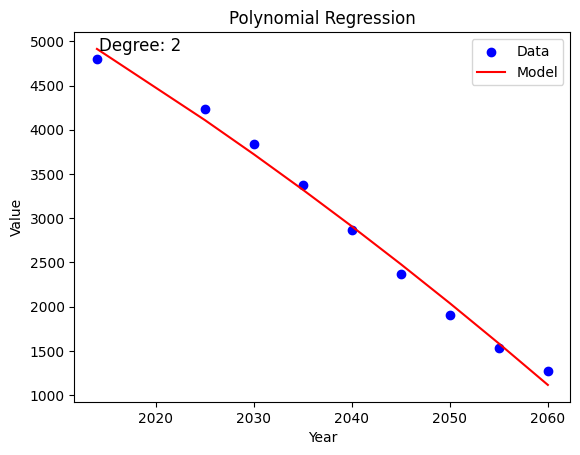

Years of reported data: [2014 2025 2030 2035 2040 2045 2050 2055 2060]


## For Reported row:


Step 1: Copy the following string of numbers:

 4804											4236					3839					3376					2863					2371					1909					1529					1268 

Step 2: In your Google Sheets, locate the cell that corresponds to the first year of the reported data.
Step 3: Paste without formatting the copied string into the located cell. The numbers will automatically fill the cells for each corresponding year.




## For interpolation row:


Step 1: Copy the following formula:

=-957985.7982736451 + 1026.3050602167557*O1^1 + -0.27219541136355474*O1^2

Step 2: In your Google Sheets, locate the cell that corresponds to the first year of the reported data.
Step 3: Paste the copied formula into the located cell. Drag or ctrl-r to fill the formula into other cells.


## List variable name: china_WTW_light_road

Poly degree testing: 2
Poly degree testing: 3
R-squared: 0.9961184355417125


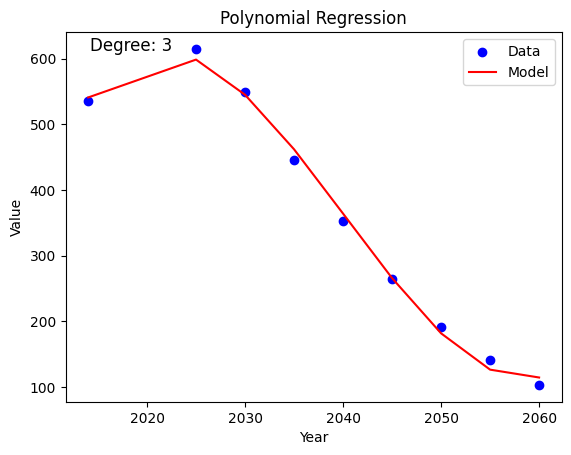

Years of reported data: [2014 2025 2030 2035 2040 2045 2050 2055 2060]


## For Reported row:


Step 1: Copy the following string of numbers:

 536											615					550					446					353					264					191					141					103 

Step 2: In your Google Sheets, locate the cell that corresponds to the first year of the reported data.
Step 3: Paste without formatting the copied string into the located cell. The numbers will automatically fill the cells for each corresponding year.




## For interpolation row:


Step 1: Copy the following formula:

=-164907369.1606045 + 242537.37761404965*O1^1 + -118.89375646662938*O1^2 + 0.0194259442796465*O1^3

Step 2: In your Google Sheets, locate the cell that corresponds to the first year of the reported data.
Step 3: Paste the copied formula into the located cell. Drag or ctrl-r to fill the formula into other cells.


## List variable name: world_WTW_heavy_road

Poly degree testing: 2
Poly degree testing: 3
R-squared: 0.9955345793917746


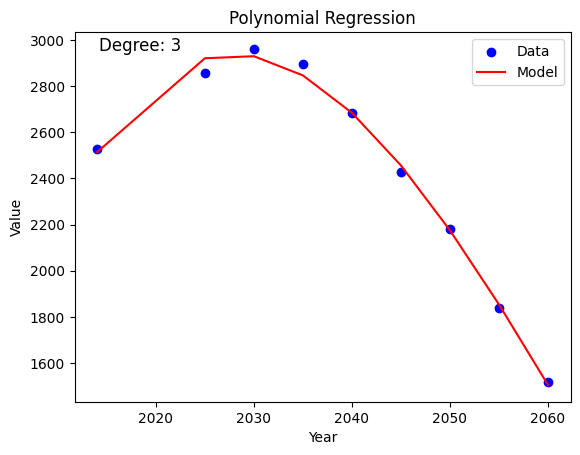

Years of reported data: [2014 2025 2030 2035 2040 2045 2050 2055 2060]


## For Reported row:


Step 1: Copy the following string of numbers:

 2527											2856					2961					2894					2683					2427					2181					1838					1518 

Step 2: In your Google Sheets, locate the cell that corresponds to the first year of the reported data.
Step 3: Paste without formatting the copied string into the located cell. The numbers will automatically fill the cells for each corresponding year.




## For interpolation row:


Step 1: Copy the following formula:

=-151872103.77898604 + 220730.6696631634*O1^1 + -106.90030672056943*O1^2 + 0.017251629556994885*O1^3

Step 2: In your Google Sheets, locate the cell that corresponds to the first year of the reported data.
Step 3: Paste the copied formula into the located cell. Drag or ctrl-r to fill the formula into other cells.


## List variable name: china_WTW_heavy_road

Poly degree testing: 2
Poly degree testing: 3
Poly degree testing: 4
Poly degree testing: 5
R-squared: 0.9884370665250543


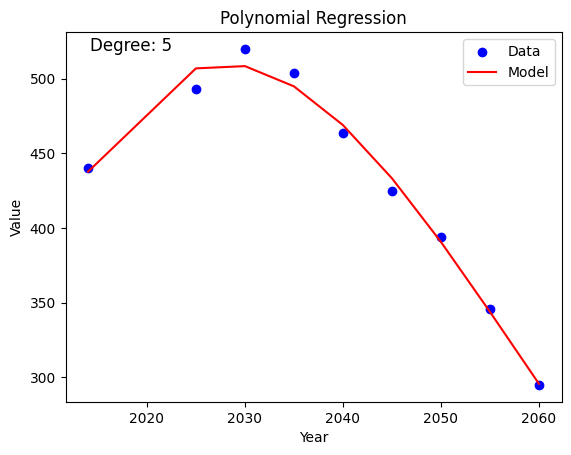

Years of reported data: [2014 2025 2030 2035 2040 2045 2050 2055 2060]


## For Reported row:


Step 1: Copy the following string of numbers:

 440											493					520					504					464					425					394					346					295 

Step 2: In your Google Sheets, locate the cell that corresponds to the first year of the reported data.
Step 3: Paste without formatting the copied string into the located cell. The numbers will automatically fill the cells for each corresponding year.




## For interpolation row:


Step 1: Copy the following formula:

=-3306290.4205721337 + -6.252653901235969e-10*O1^1 + 3.7360998766535216e-06*O1^2 + 0.003805826495304612*O1^3 + -2.775802013750001e-06*O1^4 + 5.397712273946246e-10*O1^5

Step 2: In your Google Sheets, locate the cell that corresponds to the first year of the reported data.
Step 3: Paste the copied formula into the located cell. Drag or ctrl-r to fill the formula into other cells.


## List variable name: world_light_road_activ

Poly degree testing: 2
R-squared: 0.9965463000599918


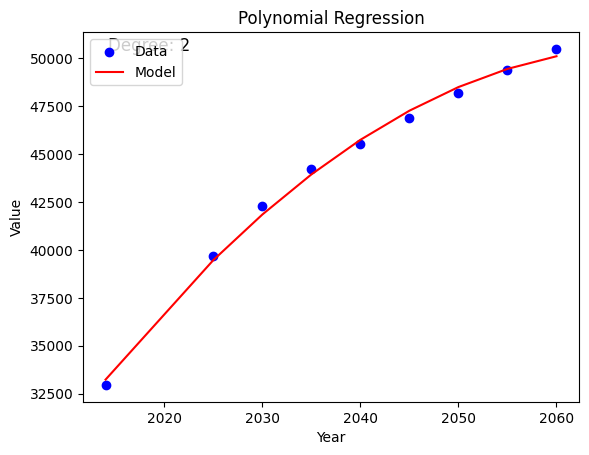

Years of reported data: [2014 2025 2030 2035 2040 2045 2050 2055 2060]


## For Reported row:


Step 1: Copy the following string of numbers:

 32959											39658					42301					44192					45511					46889					48162					49362					50478 

Step 2: In your Google Sheets, locate the cell that corresponds to the first year of the reported data.
Step 3: Paste without formatting the copied string into the located cell. The numbers will automatically fill the cells for each corresponding year.




## For interpolation row:


Step 1: Copy the following formula:

=-24435495.22412366 + 23669.032132599496*O1^1 + -5.719816883120075*O1^2

Step 2: In your Google Sheets, locate the cell that corresponds to the first year of the reported data.
Step 3: Paste the copied formula into the located cell. Drag or ctrl-r to fill the formula into other cells.


## List variable name: china_light_road_activ

Poly degree testing: 2
Poly degree testing: 3
Poly degree testing: 4
Poly degree testing: 5
R-squared: 0.9746920474165214


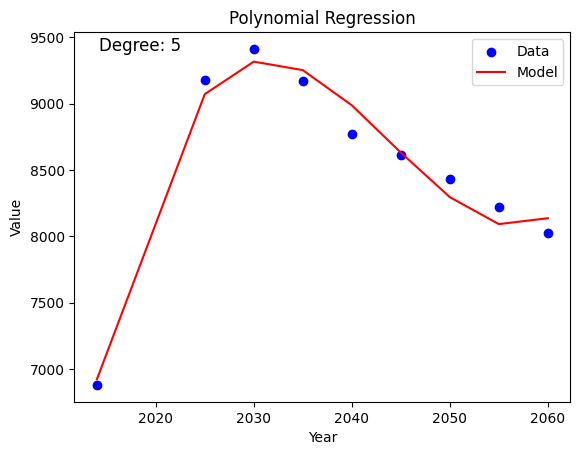

Years of reported data: [2014 2025 2030 2035 2040 2045 2050 2055 2060]


## For Reported row:


Step 1: Copy the following string of numbers:

 6879											9176					9412					9172					8773					8616					8428					8219					8027 

Step 2: In your Google Sheets, locate the cell that corresponds to the first year of the reported data.
Step 3: Paste without formatting the copied string into the located cell. The numbers will automatically fill the cells for each corresponding year.




## For interpolation row:


Step 1: Copy the following formula:

=-127255856.5780221 + -2.4491326556361374e-08*O1^1 + 0.00014634112669965378*O1^2 + 0.14907228254269492*O1^3 + -0.00010940007454492383*O1^4 + 2.140867956634477e-08*O1^5

Step 2: In your Google Sheets, locate the cell that corresponds to the first year of the reported data.
Step 3: Paste the copied formula into the located cell. Drag or ctrl-r to fill the formula into other cells.


## List variable name: world_heavy_road_activ

R-squared: 0.9925099354980996


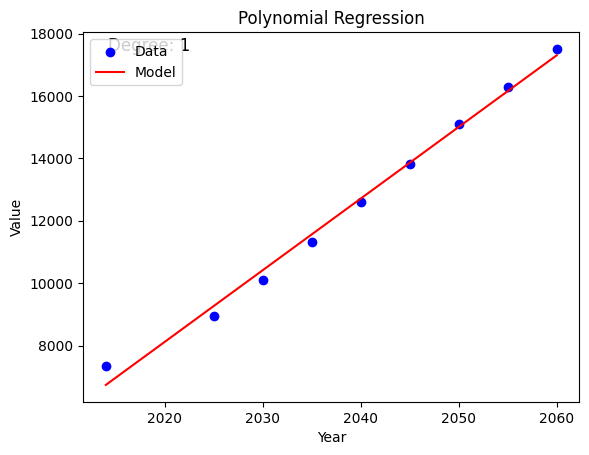

Years of reported data: [2014 2025 2030 2035 2040 2045 2050 2055 2060]


## For Reported row:


Step 1: Copy the following string of numbers:

 7343											8955					10084					11324					12588					13833					15085					16282					17507 

Step 2: In your Google Sheets, locate the cell that corresponds to the first year of the reported data.
Step 3: Paste without formatting the copied string into the located cell. The numbers will automatically fill the cells for each corresponding year.




## For interpolation row:


Step 1: Copy the following formula:

=-455864.92927012796 + 229.6930022573364*O1^1

Step 2: In your Google Sheets, locate the cell that corresponds to the first year of the reported data.
Step 3: Paste the copied formula into the located cell. Drag or ctrl-r to fill the formula into other cells.


## List variable name: china_heavy_road_activ

Poly degree testing: 2
Poly degree testing: 3
Poly degree testing: 4
Poly degree testing: 5
R-squared: 0.9877505439085866


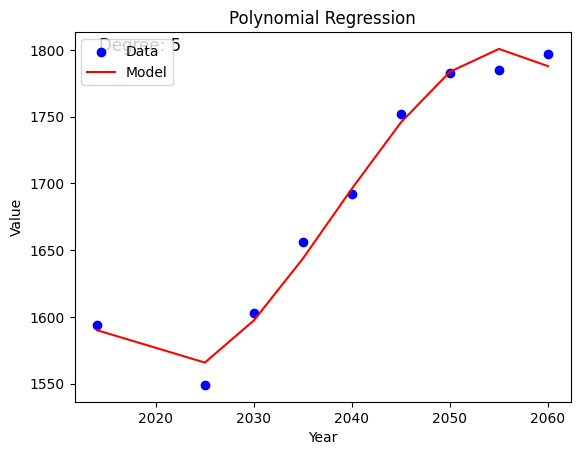

Years of reported data: [2014 2025 2030 2035 2040 2045 2050 2055 2060]


## For Reported row:


Step 1: Copy the following string of numbers:

 1594											1549					1603					1656					1692					1752					1783					1785					1797 

Step 2: In your Google Sheets, locate the cell that corresponds to the first year of the reported data.
Step 3: Paste without formatting the copied string into the located cell. The numbers will automatically fill the cells for each corresponding year.




## For interpolation row:


Step 1: Copy the following formula:

=9970479.205743827 + 1.935255297771354e-09*O1^1 + -1.1563581067450857e-05*O1^2 + -0.011779391491936176*O1^3 + 8.669190272175587e-06*O1^4 + -1.7012631833480223e-09*O1^5

Step 2: In your Google Sheets, locate the cell that corresponds to the first year of the reported data.
Step 3: Paste the copied formula into the located cell. Drag or ctrl-r to fill the formula into other cells.


## List variable name: world_light_road_freight

R-squared: 0.9975653988807415


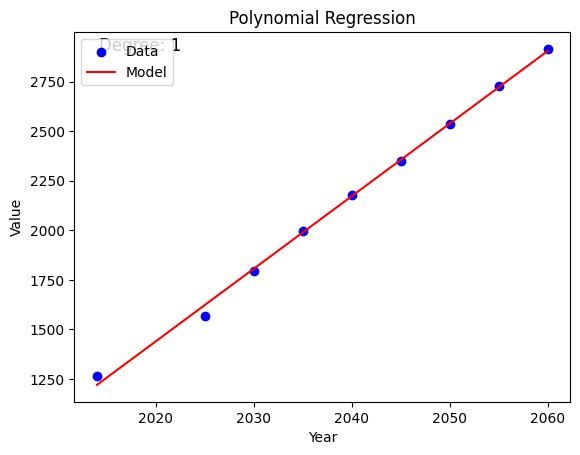

Years of reported data: [2014 2025 2030 2035 2040 2045 2050 2055 2060]


## For Reported row:


Step 1: Copy the following string of numbers:

 1266											1566					1794					1998					2179					2352					2535					2729					2915 

Step 2: In your Google Sheets, locate the cell that corresponds to the first year of the reported data.
Step 3: Paste without formatting the copied string into the located cell. The numbers will automatically fill the cells for each corresponding year.




## For interpolation row:


Step 1: Copy the following formula:

=-72541.01843491348 + 36.624341610233266*O1^1

Step 2: In your Google Sheets, locate the cell that corresponds to the first year of the reported data.
Step 3: Paste the copied formula into the located cell. Drag or ctrl-r to fill the formula into other cells.


## List variable name: china_light_road_freight

R-squared: 0.9960189309328866


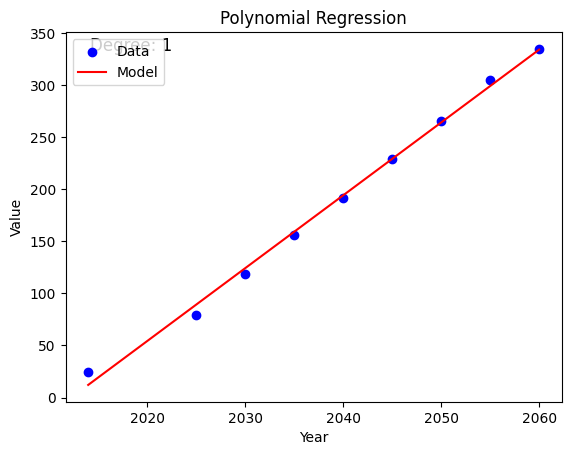

Years of reported data: [2014 2025 2030 2035 2040 2045 2050 2055 2060]


## For Reported row:


Step 1: Copy the following string of numbers:

 25											79					119					156					192					229					266					305					335 

Step 2: In your Google Sheets, locate the cell that corresponds to the first year of the reported data.
Step 3: Paste without formatting the copied string into the located cell. The numbers will automatically fill the cells for each corresponding year.




## For interpolation row:


Step 1: Copy the following formula:

=-14095.36832204666 + 7.00470278404816*O1^1

Step 2: In your Google Sheets, locate the cell that corresponds to the first year of the reported data.
Step 3: Paste the copied formula into the located cell. Drag or ctrl-r to fill the formula into other cells.


## List variable name: world_heavy_road_freight

R-squared: 0.9955849626163892


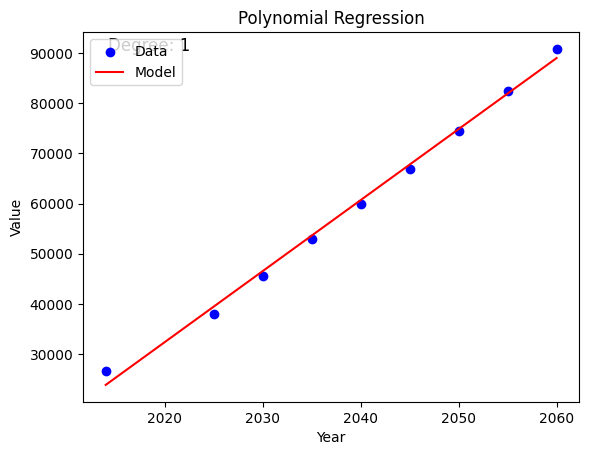

Years of reported data: [2014 2025 2030 2035 2040 2045 2050 2055 2060]


## For Reported row:


Step 1: Copy the following string of numbers:

 26523											38049					45529					52909					59878					66879					74463					82508					90850 

Step 2: In your Google Sheets, locate the cell that corresponds to the first year of the reported data.
Step 3: Paste without formatting the copied string into the located cell. The numbers will automatically fill the cells for each corresponding year.




## For interpolation row:


Step 1: Copy the following formula:

=-2831090.9010534245 + 1417.5332957110613*O1^1

Step 2: In your Google Sheets, locate the cell that corresponds to the first year of the reported data.
Step 3: Paste the copied formula into the located cell. Drag or ctrl-r to fill the formula into other cells.


## List variable name: china_heavy_road_freight

R-squared: 0.9957836724499197


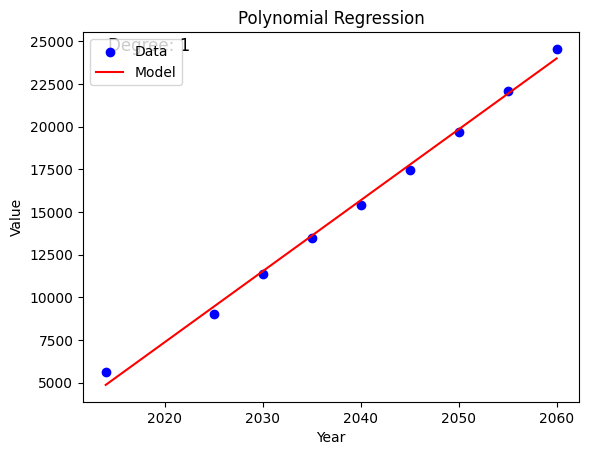

Years of reported data: [2014 2025 2030 2035 2040 2045 2050 2055 2060]


## For Reported row:


Step 1: Copy the following string of numbers:

 5604											9024					11352					13464					15437					17441					19681					22091					24562 

Step 2: In your Google Sheets, locate the cell that corresponds to the first year of the reported data.
Step 3: Paste without formatting the copied string into the located cell. The numbers will automatically fill the cells for each corresponding year.




## For interpolation row:


Step 1: Copy the following formula:

=-832957.9789315278 + 416.0007524454479*O1^1

Step 2: In your Google Sheets, locate the cell that corresponds to the first year of the reported data.
Step 3: Paste the copied formula into the located cell. Drag or ctrl-r to fill the formula into other cells.


In [ ]:
for i, values in enumerate(ETP_raw):
    print_header(f'List variable name: {variable_names[i]}')
    Sheets_formula_regression(years, values,instructions=True)

##Example 2: IEA EV Outlook Data, China and World EV data

In [ ]:
EV_data = pd.read_csv('/content/IEA Global EV Data 2024.csv') # https://www.iea.org/data-and-statistics/data-product/global-ev-outlook-2024
EV_data.index = EV_data.year
EV_data.drop('year', axis=1, inplace=True)

## Processing EV stock share for Buses in China

Poly degree testing: 2
R-squared: 0.9910537706952838


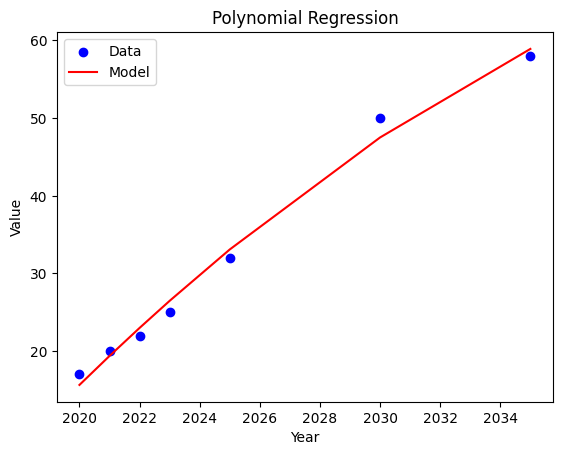

Years of reported data: [2020 2021 2022 2023 2025 2030 2035]


## For Reported row:


 17.0%	20.0%	22.0%	25.0%		32.0%					50.0%					58.0% 





## For interpolation row:


=(-254012.0330264017 + 247.72265615036562*U1^1 + -0.06037939505532108*U1^2)/100


## Processing EV stock share for Buses in World

Poly degree testing: 2
R-squared: 0.9994335545526797


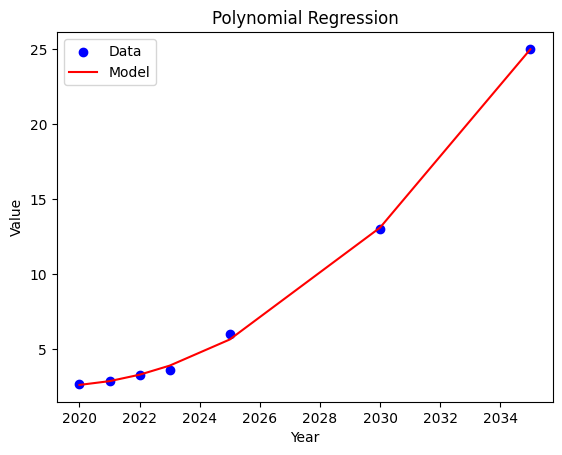

Years of reported data: [2020 2021 2022 2023 2025 2030 2035]


## For Reported row:


 2.70000004768372%	2.90000009536743%	3.29999995231628%	3.59999990463257%		6.0%					13.0%					25.0% 





## For interpolation row:


=(360663.74406700314 + -357.2526094752233*U1^1 + 0.08846906256576403*U1^2)/100


## Processing EV sales share for Buses in China

Poly degree testing: 2
Poly degree testing: 3
Poly degree testing: 4
Poly degree testing: 5
R-squared: 0.69639880701453


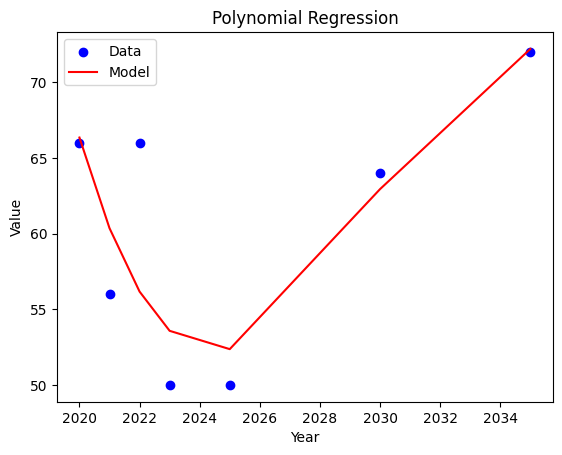

Years of reported data: [2020 2021 2022 2023 2025 2030 2035]


## For Reported row:


 66.0%	56.0%	66.0%	50.0%		50.0%					64.0%					72.0% 





## For interpolation row:


=(29050266.892857973 + -1.347592056420669e-05*U1^1 + -3.427750173347594e-05*U1^2 + -0.03474183118429283*U1^3 + 2.5674762599079688e-05*U1^4 + -5.059712797248302e-09*U1^5)/100


## Processing EV sales share for Buses in World

Poly degree testing: 2
Poly degree testing: 3
Poly degree testing: 4
Poly degree testing: 5
R-squared: 0.9811147769686385


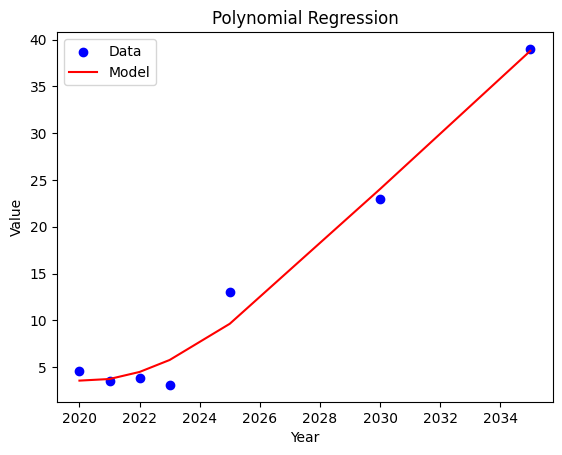

Years of reported data: [2020 2021 2022 2023 2025 2030 2035]


## For Reported row:


 4.59999990463257%	3.5%	3.79999995231628%	3.09999990463257%		13.0%					23.0%					39.0% 





## For interpolation row:


=(8936657.29478545 + -4.14345341458577e-06*U1^1 + -1.0539334283863535e-05*U1^2 + -0.010682102078275881*U1^3 + 7.892629714139941e-06*U1^4 + -1.555051768097751e-09*U1^5)/100


## Processing EV sales for BEV Buses in China

Poly degree testing: 2
Poly degree testing: 3
Poly degree testing: 4
Poly degree testing: 5
R-squared: 0.4109133036832119


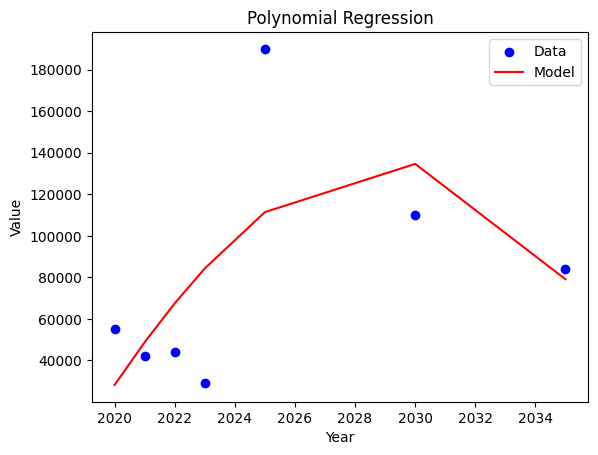

Years of reported data: [2020 2021 2022 2023 2025 2030 2035]


## For Reported row:


 55000.0	42000.0	44000.0	29000.0		190000.0					110000.0					84000.0 





## For interpolation row:


=19163287402.816936 + -0.00918542082617513*U1^1 + -0.023364138714387764*U1^2 + -23.68063363847264*U1^3 + 0.017688744916145617*U1^4 + -3.5230806642548573e-06*U1^5



## Processing EV sales for BEV Buses in World

Poly degree testing: 2
Poly degree testing: 3
Poly degree testing: 4
Poly degree testing: 5
R-squared: 0.9790647810558869


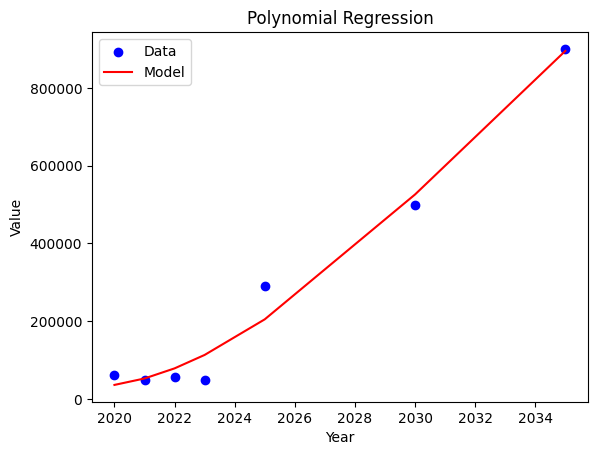

Years of reported data: [2020 2021 2022 2023 2025 2030 2035]


## For Reported row:


 62000.0	50000.0	58000.0	48000.0		290000.0					500000.0					900000.0 





## For interpolation row:


=118381445481.65404 + -0.054734109401375935*U1^1 + -0.13922229071823994*U1^2 + -141.10822195796982*U1^3 + 0.10415911632828696*U1^4 + -2.050181422142555e-05*U1^5



## Processing EV stock for PHEV and BEV Buses in China

Poly degree testing: 2
Poly degree testing: 3
R-squared: 0.9979172451597912


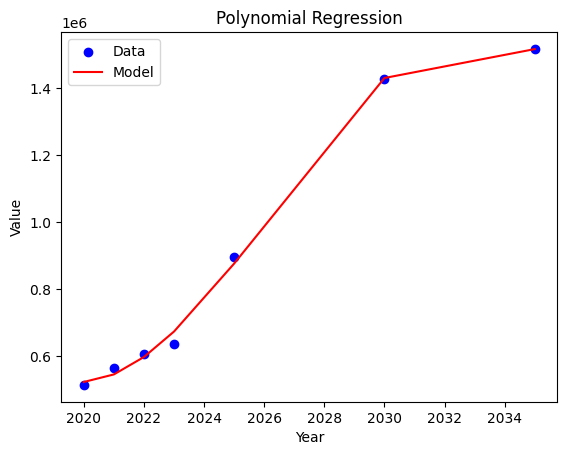

Years of reported data: [2020 2021 2022 2023 2025 2030 2035]


## For Reported row:


 514000.0	565000.0	606000.0	637000.0		895000.0					1426000.0					1516000.0 





## For interpolation row:


=7407643857809.9795 + -10966395919.286757*U1^1 + 5411552.1169220265*U1^2 + -890.1307525634766*U1^3



## Processing EV stock for PHEV and BEV Buses in World

Poly degree testing: 2
R-squared: 0.9996961562900197


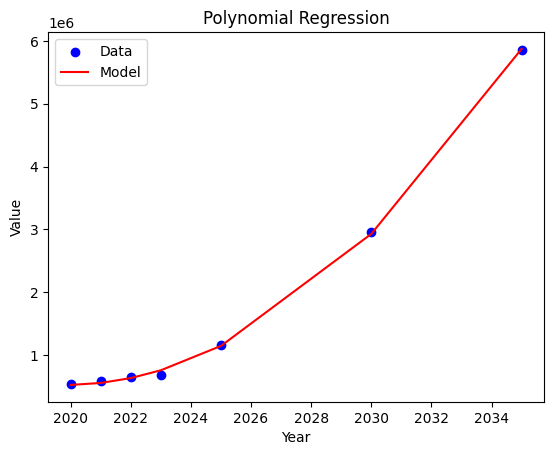

Years of reported data: [2020 2021 2022 2023 2025 2030 2035]


## For Reported row:


 535000.0	587000.0	648000.0	689000.0		1157000.0					2960000.0					5860000.0 





## For interpolation row:


=94709060214.80846 + -93778845.9237648*U1^1 + 23214.57129408419*U1^2



In [ ]:
#segmented market data

# Create some data
print_header("Processing EV stock share for Buses in China")
x = EV_data[(EV_data['region'] == 'China') & (EV_data['mode'] == 'Buses')& (EV_data['parameter'] == 'EV stock share') & (EV_data['category'] == 'Projection-APS')].index.values
y = EV_data[(EV_data['region'] == 'China') & (EV_data['mode'] == 'Buses')& (EV_data['parameter'] == 'EV stock share') & (EV_data['category'] == 'Projection-APS')]['value'].values
Sheets_formula_regression(x, y,pct=True,instructions=False)

# Create some data
print_header("Processing EV stock share for Buses in World")
x = EV_data[(EV_data['region'] == 'World') & (EV_data['mode'] == 'Buses')& (EV_data['parameter'] == 'EV stock share') & (EV_data['category'] == 'Projection-APS')].index.values
y = EV_data[(EV_data['region'] == 'World') & (EV_data['mode'] == 'Buses')& (EV_data['parameter'] == 'EV stock share') & (EV_data['category'] == 'Projection-APS')]['value'].values
Sheets_formula_regression(x, y,pct=True,instructions=False)

#BUS EV SALES

# Create some data
print_header("Processing EV sales share for Buses in China")
x =EV_data[(EV_data['region'] == 'China') & (EV_data['mode'] == 'Buses') & (EV_data['parameter'] == 'EV sales share') & (EV_data['category'] == 'Projection-APS')].index.values
y = EV_data[(EV_data['region'] == 'China') & (EV_data['mode'] == 'Buses') & (EV_data['parameter'] == 'EV sales share') & (EV_data['category'] == 'Projection-APS')]['value'].values
Sheets_formula_regression(x, y,pct=True,instructions=False)

# Create some data
print_header("Processing EV sales share for Buses in World")
x =EV_data[(EV_data['region'] == 'World') & (EV_data['mode'] == 'Buses') & (EV_data['parameter'] == 'EV sales share') & (EV_data['category'] == 'Projection-APS')].index.values
y = EV_data[(EV_data['region'] == 'World') & (EV_data['mode'] == 'Buses') & (EV_data['parameter'] == 'EV sales share') & (EV_data['category'] == 'Projection-APS')]['value'].values
Sheets_formula_regression(x, y,pct=True,instructions=False)
# Create some data
print_header("Processing EV sales for BEV Buses in China")
x = EV_data[(EV_data['region'] == 'China') & (EV_data['powertrain'] == 'BEV') & (EV_data['mode'] == 'Buses') & (EV_data['parameter'] == 'EV sales') & (EV_data['category'] == 'Projection-APS')].index.values
y = EV_data[(EV_data['region'] == 'China') & (EV_data['powertrain'] == 'BEV') & (EV_data['mode'] == 'Buses') & (EV_data['parameter'] == 'EV sales') & (EV_data['category'] == 'Projection-APS')]['value'].values
Sheets_formula_regression(x, y,instructions=False)

# Create some data
print_header("Processing EV sales for BEV Buses in World")
x = EV_data[(EV_data['region'] == 'World') & (EV_data['powertrain'] == 'BEV') & (EV_data['mode'] == 'Buses') & (EV_data['parameter'] == 'EV sales') & (EV_data['category'] == 'Projection-APS')].index.values
y = EV_data[(EV_data['region'] == 'World') & (EV_data['powertrain'] == 'BEV') & (EV_data['mode'] == 'Buses') & (EV_data['parameter'] == 'EV sales') & (EV_data['category'] == 'Projection-APS')]['value'].values
Sheets_formula_regression(x, y,instructions=False)



#EV STOCK

print_header("Processing EV stock for PHEV and BEV Buses in China")
China_PHEV_BEV = EV_data[(EV_data['region'] == 'China') & (EV_data['parameter'] == 'EV stock') & (EV_data['powertrain'] == 'PHEV') & (EV_data['mode'] == 'Buses') &  (EV_data['category'] == 'Projection-APS')]['value'] +\
EV_data[(EV_data['region'] == 'China') & (EV_data['parameter'] == 'EV stock') & (EV_data['powertrain'] == 'BEV') & (EV_data['mode'] == 'Buses') &  (EV_data['category'] == 'Projection-APS')]['value']

# Create some data
x = China_PHEV_BEV.index.values
y = China_PHEV_BEV.values
Sheets_formula_regression(x, y,instructions=False)

print_header("Processing EV stock for PHEV and BEV Buses in World")
World_PHEV_BEV = EV_data[(EV_data['region'] == 'World') & (EV_data['parameter'] == 'EV stock') & (EV_data['powertrain'] == 'PHEV') & (EV_data['mode'] == 'Buses') &  (EV_data['category'] == 'Projection-APS')]['value'] +\
EV_data[(EV_data['region'] == 'World') & (EV_data['parameter'] == 'EV stock') & (EV_data['powertrain'] == 'BEV') & (EV_data['mode'] == 'Buses') &  (EV_data['category'] == 'Projection-APS')]['value']

# Create some data
x = World_PHEV_BEV.index.values
y = World_PHEV_BEV.values

Sheets_formula_regression(x, y,2010,instructions=False)


##Example 3: SDA data

In [ ]:
MoMo = pd.read_csv('/content/SDA-Transport-tool - Data2DS - for csv export.csv',).T
MoMo.columns = MoMo.iloc[0]

# Find the indices of the columns that contain 'Transport mode/category'
category_indices = [idx for idx, col in enumerate(MoMo.columns) if col == 'Transport mode/category']

# Initialize a list to hold the new column tuples
new_columns = []

# Iterate through the columns
for idx, col in enumerate(MoMo.columns):
    # Check if the current index is in the category_indices list
    if idx in category_indices:
        # Set the multicolumn header to the previous column's header
        multicolumn_header = MoMo.columns[idx - 1] if idx > 0 else 'WTW emissions (MT CO2)'
    # Append the tuple to the new_columns list
    new_columns.append((multicolumn_header, col))

# Create a MultiIndex with the new columns
MoMo.columns = pd.MultiIndex.from_tuples(new_columns)

MoMo.index = MoMo.iloc[:,0]
MoMo.index.name = 'Year'
MoMo = MoMo.iloc[1:]
# Drop columns where the column name is 'Transport mode/category'
MoMo = MoMo.loc[:, MoMo.columns.get_level_values(1) != 'Transport mode/category']


def remove_commas_from_df(df):
  """
  This function converts all values in a DataFrame to numeric, handling commas in numbers.

  Args:
      df (pd.DataFrame): The DataFrame to be converted.

  Returns:
      pd.DataFrame: The converted DataFrame.
  """

  # Iterate through each column
  for column in df.columns:
    # Check if the column contains numbers
    if df[column].dtype == object:
      # Replace commas with empty strings
      df[column] = df[column].str.replace(',', '')
      # Convert the column to numeric
      df[column] = pd.to_numeric(df[column])

  return df


MoMo = remove_commas_from_df(MoMo)
MoMo.index = MoMo.index.astype(int)

###No interpolation needed

In [ ]:
print_header("Processing WTW emissions (MT CO2) for Passenger - Buses")
reported_data_to_sheet(MoMo['WTW emissions (MT CO2)']['Passenger - Buses'].loc[2010:2035].index,
                       MoMo['WTW emissions (MT CO2)']['Passenger - Buses'].loc[2010:2035].values,instructions=False)

print_header("Processing WTW emissions (MT CO2) for Passenger - Mini-buses")
reported_data_to_sheet(MoMo['WTW emissions (MT CO2)']['Passenger - Mini-buses'].loc[2010:2035].index,
                       MoMo['WTW emissions (MT CO2)']['Passenger - Mini-buses'].loc[2010:2035].values,instructions=False)

print_header("Processing Activity (billion pkm, tkm) for Passenger - Buses")
reported_data_to_sheet(MoMo['Activity (billion pkm, tkm)']['Passenger - Buses'].loc[2010:2035].index,
                       MoMo['Activity (billion pkm, tkm)']['Passenger - Buses'].loc[2010:2035].values,instructions=False)


print_header("Processing Activity (billion pkm, tkm) for Passenger - Mini-buses")
reported_data_to_sheet(MoMo['Activity (billion pkm, tkm)']['Passenger - Mini-buses'].loc[2010:2035].index,
                       MoMo['Activity (billion pkm, tkm)']['Passenger - Mini-buses'].loc[2010:2035].values,instructions=False)



## Processing WTW emissions (MT CO2) for Passenger - Buses

Years of reported data: Index([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021,
       2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033,
       2034, 2035],
      dtype='int64', name='Year')


## For Reported row:


 257.31	264.31	271.3	278.29	285.29	292.28	286.19	280.1	274.01	267.92	261.83	257.92	254.01	250.09	246.18	242.27	239.44	236.61	233.77	230.94	228.11	225.19	222.27	219.35	216.43	213.51 



## Processing WTW emissions (MT CO2) for Passenger - Mini-buses

Years of reported data: Index([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021,
       2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033,
       2034, 2035],
      dtype='int64', name='Year')


## For Reported row:


 189.79	193.11	196.44	199.77	203.09	206.42	202.75	199.08	195.41	191.75	188.08	187.98	187.89	187.79	187.7	187.6	186.86	186.11	185.36	184.62	183.87	182.02	180.18	178.33	176.49	174.64 



## Processing Activity (billion pkm, tkm) for Passenger - Buses

Years of reported data: Index([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021,
       2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033,
       2034, 2035],
      dtype='int64', name='Year')


## For Reported row:


 5746.88	6066.17	6385.46	6704.76	7024.05	7343.34	7483.31	7623.28	7763.24	7903.21	8043.18	8225.48	8407.78	8590.08	8772.38	8954.68	9180.56	9406.45	9632.33	9858.22	10084.1	10332.09	10580.08	10828.08	11076.07	11324.06 



## Processing Activity (billion pkm, tkm) for Passenger - Mini-buses

Years of reported data: Index([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021,
       2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033,
       2034, 2035],
      dtype='int64', name='Year')


## For Reported row:


 2370.68	2456.68	2542.68	2628.68	2714.68	2800.68	2841.43	2882.17	2922.91	2963.65	3004.4	3071.54	3138.68	3205.82	3272.96	3340.1	3418.99	3497.89	3576.78	3655.68	3734.57	3822.26	3909.95	3997.64	4085.33	4173.02 

